-Satwik Arawalli

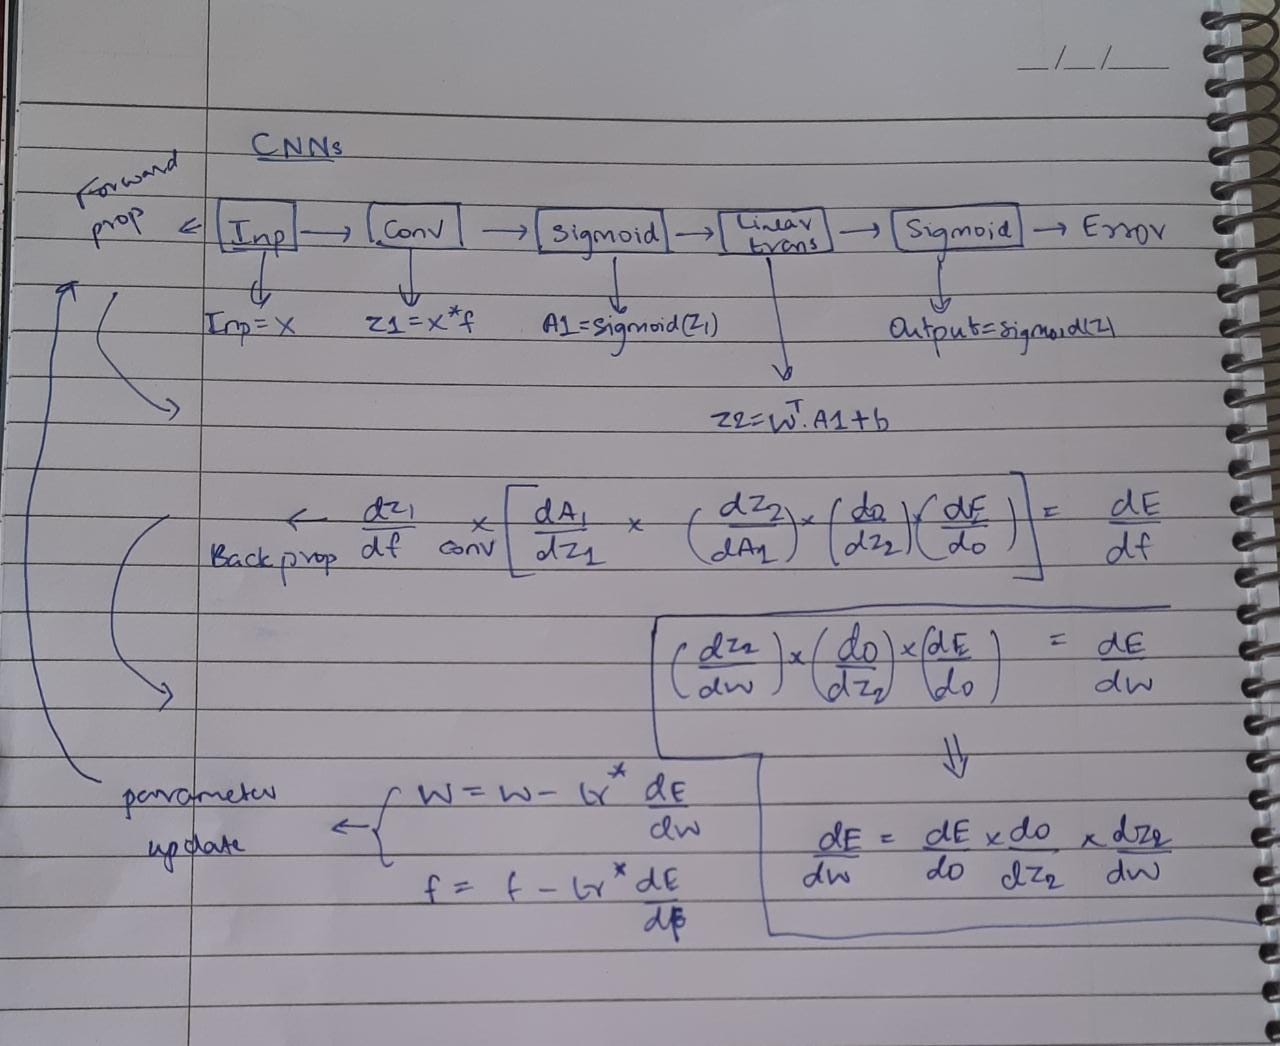



In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from keras.datasets import mnist

In [ ]:
#will be using mnist dataset for binary classification
(X_train, y_train), (X_test,y_test) = mnist.load_data()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train = X_train[:200]
y_train = y_train[:200]

X = X_train.T

X = X/25

y = y_train

y.resize(y.shape[0],1)
y = y.T

In [ ]:
pd.Series(y[0]).value_counts()

In [ ]:
#we'll be doing a binary classification, so all digits > 4 correspond to 1, others to 0 
for i in range (y.shape[1]):
  if(y[0][i]>4):
    y[0][i] = 1
  else:
    y[0][i] = 0

pd.Series(y[0]).value_counts()

In [ ]:
f = np.random.uniform(size=(3,5,5)) #initialize a random filter
f = f.T

In [ ]:
X.shape, y.shape, f.shape

In [ ]:
#Generating patches from images (patches of size 5*5 since this is the size of filter)
new_image = []

for k in range(X.shape[2]):
  for i in range(X.shape[0] - f.shape[0]+1):
    for j in range(X.shape[1] - f.shape[1]+1):
      new_image.append(X[:,:,k][i:i+f.shape[0],j:j+f.shape[1]])


#resizing the generated patches 
new_image = np.array(new_image)
new_image.resize(X.shape[2],int(new_image.shape[0]/X.shape[2]),new_image.shape[1],new_image.shape[2])
new_image.shape


In [ ]:
# len(new_image)/new_image[0].shape[0]
new_image[0].shape[1]

In [ ]:
#Initializing the weights matrix
s_rw = X.shape[0] - f.shape[0]+1
s_col = X.shape[1] - f.shape[1]+1
num_filter = f.shape[2]

inp_neu = s_rw*s_col*num_filter
out_neu = 1

w = np.random.uniform(size = (inp_neu,out_neu))


In [ ]:
#code for activation function
def sig(x):
  return 1/(1+np.exp(-x))

def d_sig(x):
  return x*(1-x)



In [ ]:
new_image.shape[1]

In [ ]:
#code for convolving
feature_maps = []
for i in range(len(new_image)):
  for k in range(f.shape[2]):
    for j in range(new_image.shape[1]):
      feature_maps.append((new_image[i][j]*f[:,:,k]).sum())


In [ ]:
#resizing and applying sigmoid function
feature_maps = np.resize(np.array(feature_maps), (len(new_image), f.shape[2], new_image.shape[1]))
fm_sig = sig(feature_maps)

feature_maps.shape, fm_sig.shape

In [ ]:
#reshaping the fm_sigs array for the feeding it to the next fully connected layer
fm_sig = fm_sig.reshape(fm_sig.shape[0], fm_sig.shape[1]*fm_sig.shape[2])
fm_sig = fm_sig.T

In [ ]:
#Linear transformation for fully connected layer
dotp = np.dot(w.T,fm_sig)
dotp = (dotp - np.average(dotp))/(np.std(dotp))
print(dotp.shape)
#applying the activation function on this dotp to generate the final output
outp = sig(dotp)

In [ ]:
#defining derivatives for backward prop to update fully-connected layer parameters
error = np.square(y - outp)/2

err_wrt_outp = -(y-outp)

outp_wrt_dotp = outp*(1-outp)

dotp_wrt_w = fm_sig



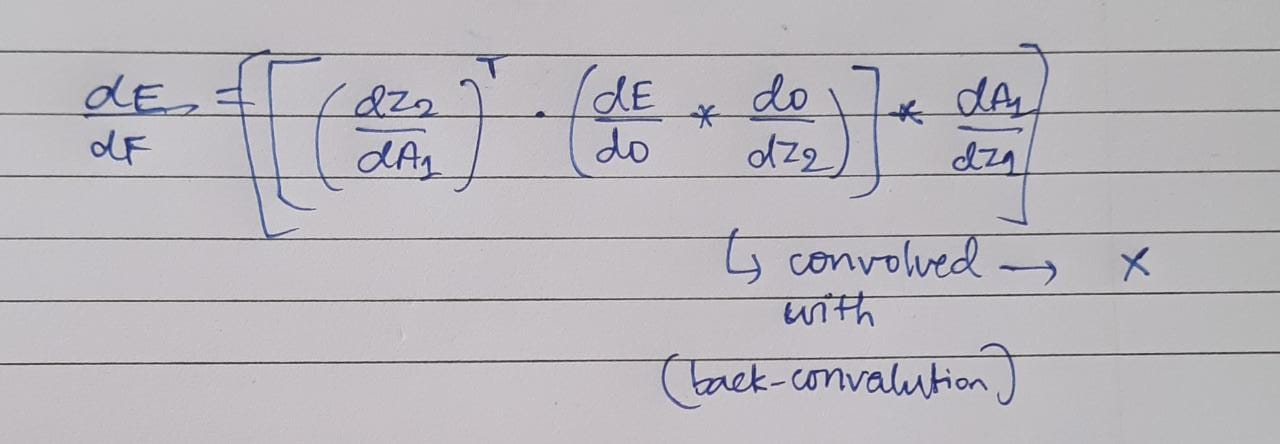

In [ ]:
#defining derivatives to update filter values
dotp_wrt_fm_sig = w.T

fm_sig_wrt_feature_maps = d_sig(fm_sig)

fm_sig_wrt_filters = X

In [ ]:
#performing 'back-convolution' or 're-convolution' to find derivative of error wrt filters
err_wrt_feature_maps = np.dot(dotp_wrt_fm_sig.T, err_wrt_outp*outp_wrt_dotp)*fm_sig_wrt_feature_maps

err_wrt_feature_maps = np.average(err_wrt_feature_maps, axis =1)

err_wrt_feature_maps = np.resize(err_wrt_feature_maps, (X.shape[0]-f.shape[0]+1,  X.shape[1]-f.shape[1]+1, f.shape[2]))


In [ ]:
filter_upd =[]
for i in range(f.shape[2]):
  for j in range(f.shape[0]):
    for k in range(f.shape[1]):
      temp = 0
      spos_row = j
      spos_col = k
      epos_row = spos_row + s_rw
      epos_col = spos_col + s_col
      for l in range(X.shape[2]):
        temp += (X[spos_row:epos_row,spos_col:epos_col,l]*err_wrt_feature_maps[:,:,i]).sum()
      filter_upd.append(temp/X.shape[2])
    
filtupar = np.array(filter_upd)
filtupar = np.resize(filtupar, (f.shape[2], f.shape[0], f.shape[1]))

In [ ]:
#update w and f 
lr = 0.01
w = w - lr*(err_wrt_outp*outp_wrt_dotp*dotp_wrt_w)

for i in range(f.shape[2]):
  f[:,:,i] = f[:,:,i] - lr*filtupar[i]